## Transpilation

We begin by defining a circuit and using the built in qiskit transpiler to put it into the (u,cp) gate-set.

In [1]:
from qiskit.circuit.library import QFT
from disqco.circuits.cp_fraction import cp_fraction
from qiskit import transpile
from QASMBench.interface.qiskit import QASMBenchmark


num_qubits = 10

circuit = cp_fraction(num_qubits, num_qubits, fraction=0.5)

# circuit = QFT(num_qubits, do_swaps=False)

num_partitions = 2 # Define the number of partitions or QPUs you will distribute over

qpu_size = num_qubits // num_partitions + 1 # Define the number of qubits per QPU. For simplicity, we divide qubits evenly and add one additional space to each for teleportation (an extra space is needed for the teleportation qubit so the algorithmr requires it!)
qpu_info = [qpu_size] * num_partitions # Store the number of qubits per QPU in a list

basis_gates = ['u', 'cp']

# Transpile the circuit to the basis gates
circuit = transpile(circuit, basis_gates=basis_gates)

print(circuit.depth())

10


# Graph conversion

We now convert the circuit to the GCP Hypergraph using a number of predefined functions which can be found in the src code.

There is an optional parameter in the 'map_circuit_to_hypergraph' function called 'group_gates'. If this is set to false, then we get a regular graph with state edges connecting qubit nodes at successive time steps, and state edges for each two-qubit gate. If group_gates is set to true, then a pass is applied which merges some of these gate edges into hyper-edges. This makes the graph structure a bit more complex, so avoid it for now. We can tackle that later.

We will also set the 'assignment' which is our problem variable. It's a matrix of dimension $depth \times num\_qubits$. Assignment[t][q] indicates the partition qubit $q$ is assigned to at time $t$. This corresponds to node $(q,t)$. The initial assignment just maps qubits in a greedy fashion, squeezing qubits onto the first QPU until its full then moving to the next. The assignment at $t=0$ is then used for the full depth.

In [2]:
from disqco.graphs.GCP_hypergraph import QuantumCircuitHyperGraph
from disqco.parti.FM.FM_methods import set_initial_partitions

depth = circuit.depth()

graph= QuantumCircuitHyperGraph(circuit, group_gates=False, anti_diag=True, map_circuit=True)

graph_grouped = QuantumCircuitHyperGraph(circuit, group_gates=True, anti_diag=True, map_circuit=True)


assignment = set_initial_partitions(qpu_info, num_qubits, depth, num_partitions, reduced = True)


If you want to look at the graph, you can use the following code to draw it. It's just something that's been thrown together so doesn't work very well and you have to play around with the scale but it can be useful to see what's going on.

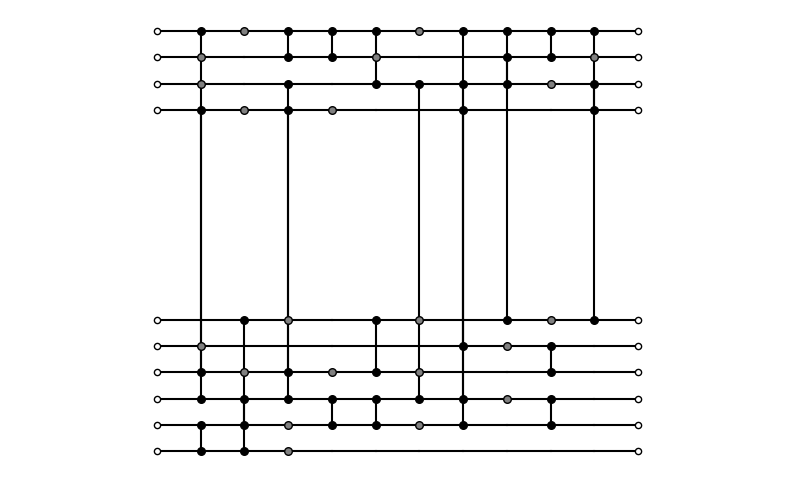

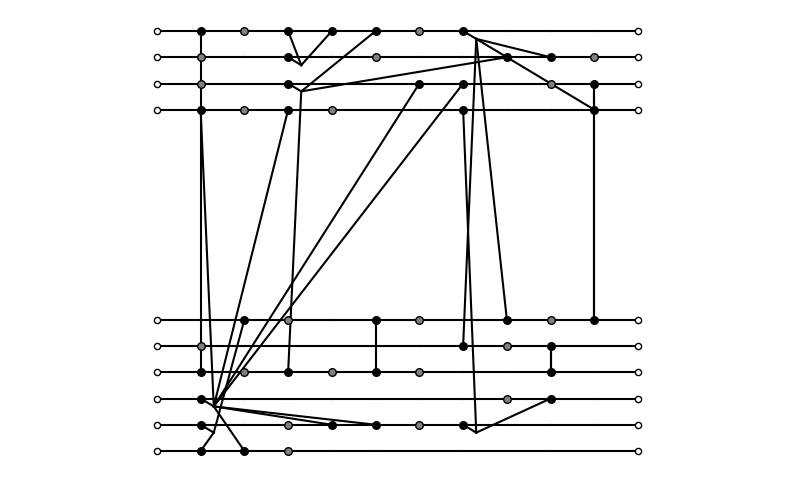

In [3]:
from disqco.drawing.mpl_drawing import hypergraph_to_matplotlib

mpl_fig = hypergraph_to_matplotlib(
    graph, 
    num_qubits,
    assignment,
    qpu_info,
    depth,
    xscale=10/depth,
    yscale=6/num_qubits,
    figsize=(10, 6),
    save=False,
    path=None,
    ax=None
)


mpl_fig = hypergraph_to_matplotlib(
    graph_grouped, 
    num_qubits,
    assignment,
    qpu_info,
    depth,
    xscale=10/depth,
    yscale=6/num_qubits,
    figsize=(10, 6),
    save=False,
    path=None,
    ax=None
)

The next few steps are all wrapped up in the optimisation routine. I will add more to show what's going on under the hood but for now I'll just show how to generate the result.

## Partitioning

I will just include the standard Fiduccia-Mattheyses heuristic here, which doesn't do any coarsening. Don't worry about all the kwargs and parameters too much. The final cost will be the entanglement cost, the final assignment is the optimised mapping of nodes to partitions (qubits to QPUs at each t) and the cost list is just the cost after each pass of the algorithm which is used for benchmarking,

In [4]:
from disqco.parti.FM.FM_main import run_FM

node_counts = len(graph.nodes)

move_limit = node_counts * 0.125

final_cost, final_assignment, cost_list = run_FM(
    graph,
    assignment,
    qpu_info,
    num_partitions,
    limit=move_limit,
    max_gain=4,
    passes=100,
    stochastic=True,
    active_nodes=graph.nodes,
    log=False,
    add_initial=False,
    costs=None
)

print(f'Final cost: {final_cost}')


Final cost: 4


If you want you can use the drawing tool to see what the new solution looks like, where the nodes are dragged around to match the assignment. The assignment variable will have to be replaced with final_assignment now! If it's working properly you should see two (or however many partitions you have) sub-graphs which are connected only by the non-local/cutting edges. You can count them to make sure it corresponds to the final cost (although this gets messy for big graphs and when hyper-edge are introduced)

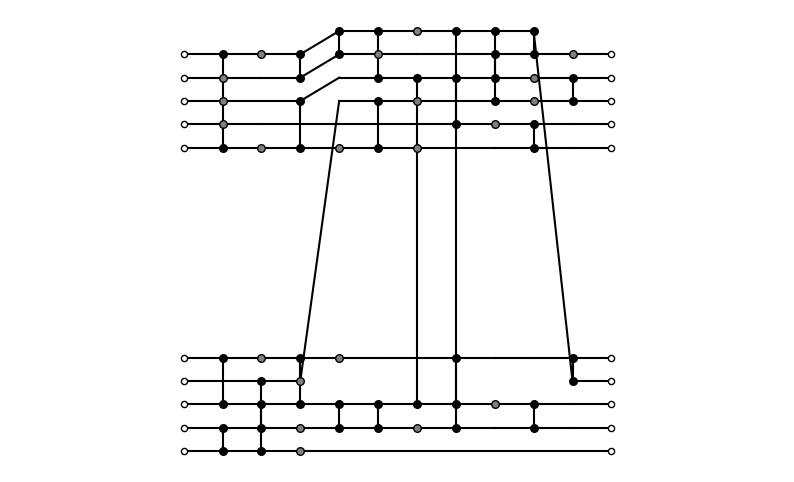

In [5]:
mpl_fig = hypergraph_to_matplotlib(
    graph, 
    num_qubits,
    final_assignment,
    qpu_info,
    depth,
    xscale=10/depth,
    yscale=6/num_qubits,
    figsize=(10, 6),
    save=False,
    path=None,
    ax=None
)

Below is just an example of a mutli-level algorithm which has used a coarsening routine. You can see that the solution should be better and the figure should look a bit cleaner too.

In [6]:
from disqco.parti.FM.FM_main import run_FM

node_counts = len(graph.nodes)

move_limit = node_counts * 0.125

final_cost_grouped, final_assignment_grouped, cost_list_grouped = run_FM(
    graph_grouped,
    assignment,
    qpu_info,
    num_partitions,
    limit=move_limit,
    max_gain=4,
    passes=100,
    stochastic=True,
    active_nodes=graph_grouped.nodes,
    log=False,
    add_initial=False,
    costs=None
)

print(f'Final cost: {final_cost_grouped}')


Final cost: 5


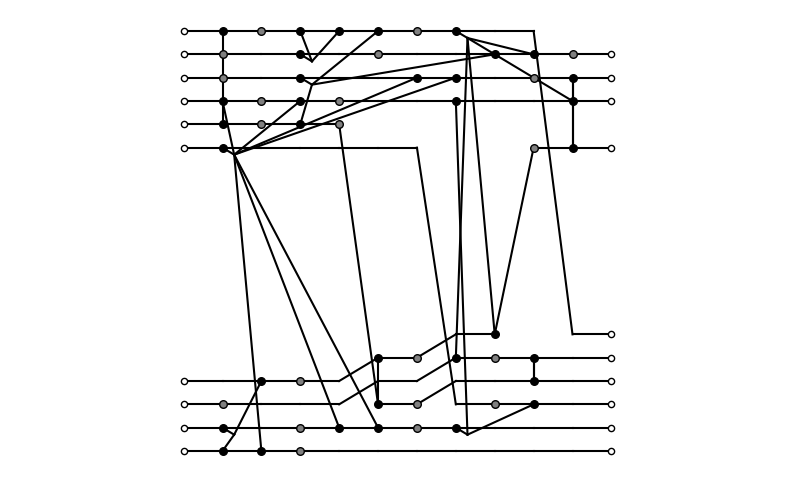

In [7]:
mpl_fig = hypergraph_to_matplotlib(
    graph_grouped, 
    num_qubits,
    final_assignment_grouped,
    qpu_info,
    depth,
    xscale=10/depth,
    yscale=6/num_qubits,
    figsize=(10, 6),
    save=False,
    path=None,
    ax=None
)

# Circuit extraction



In [8]:
from disqco.circuit_extraction.circuit_extractor import PartitionedCircuitExtractor

extractor = PartitionedCircuitExtractor(graph=graph, 
                                        partition_assignment=final_assignment, 
                                        qpu_info=qpu_info, 
                                        comm_info=[1]*num_partitions)

final_circuit = extractor.extract_partitioned_circuit()

Decomposed circuit depth: 65
Number of communication qubits needed: 2


/Users/ftb123/MLQCP_FM/.venv/lib/python3.13/site-packages/qiskit/circuit/quantumcircuit.py:3394: RuntimeWarning: Cregbundle set to False since an instruction needs to refer to individual classical wire
  return circuit_drawer(


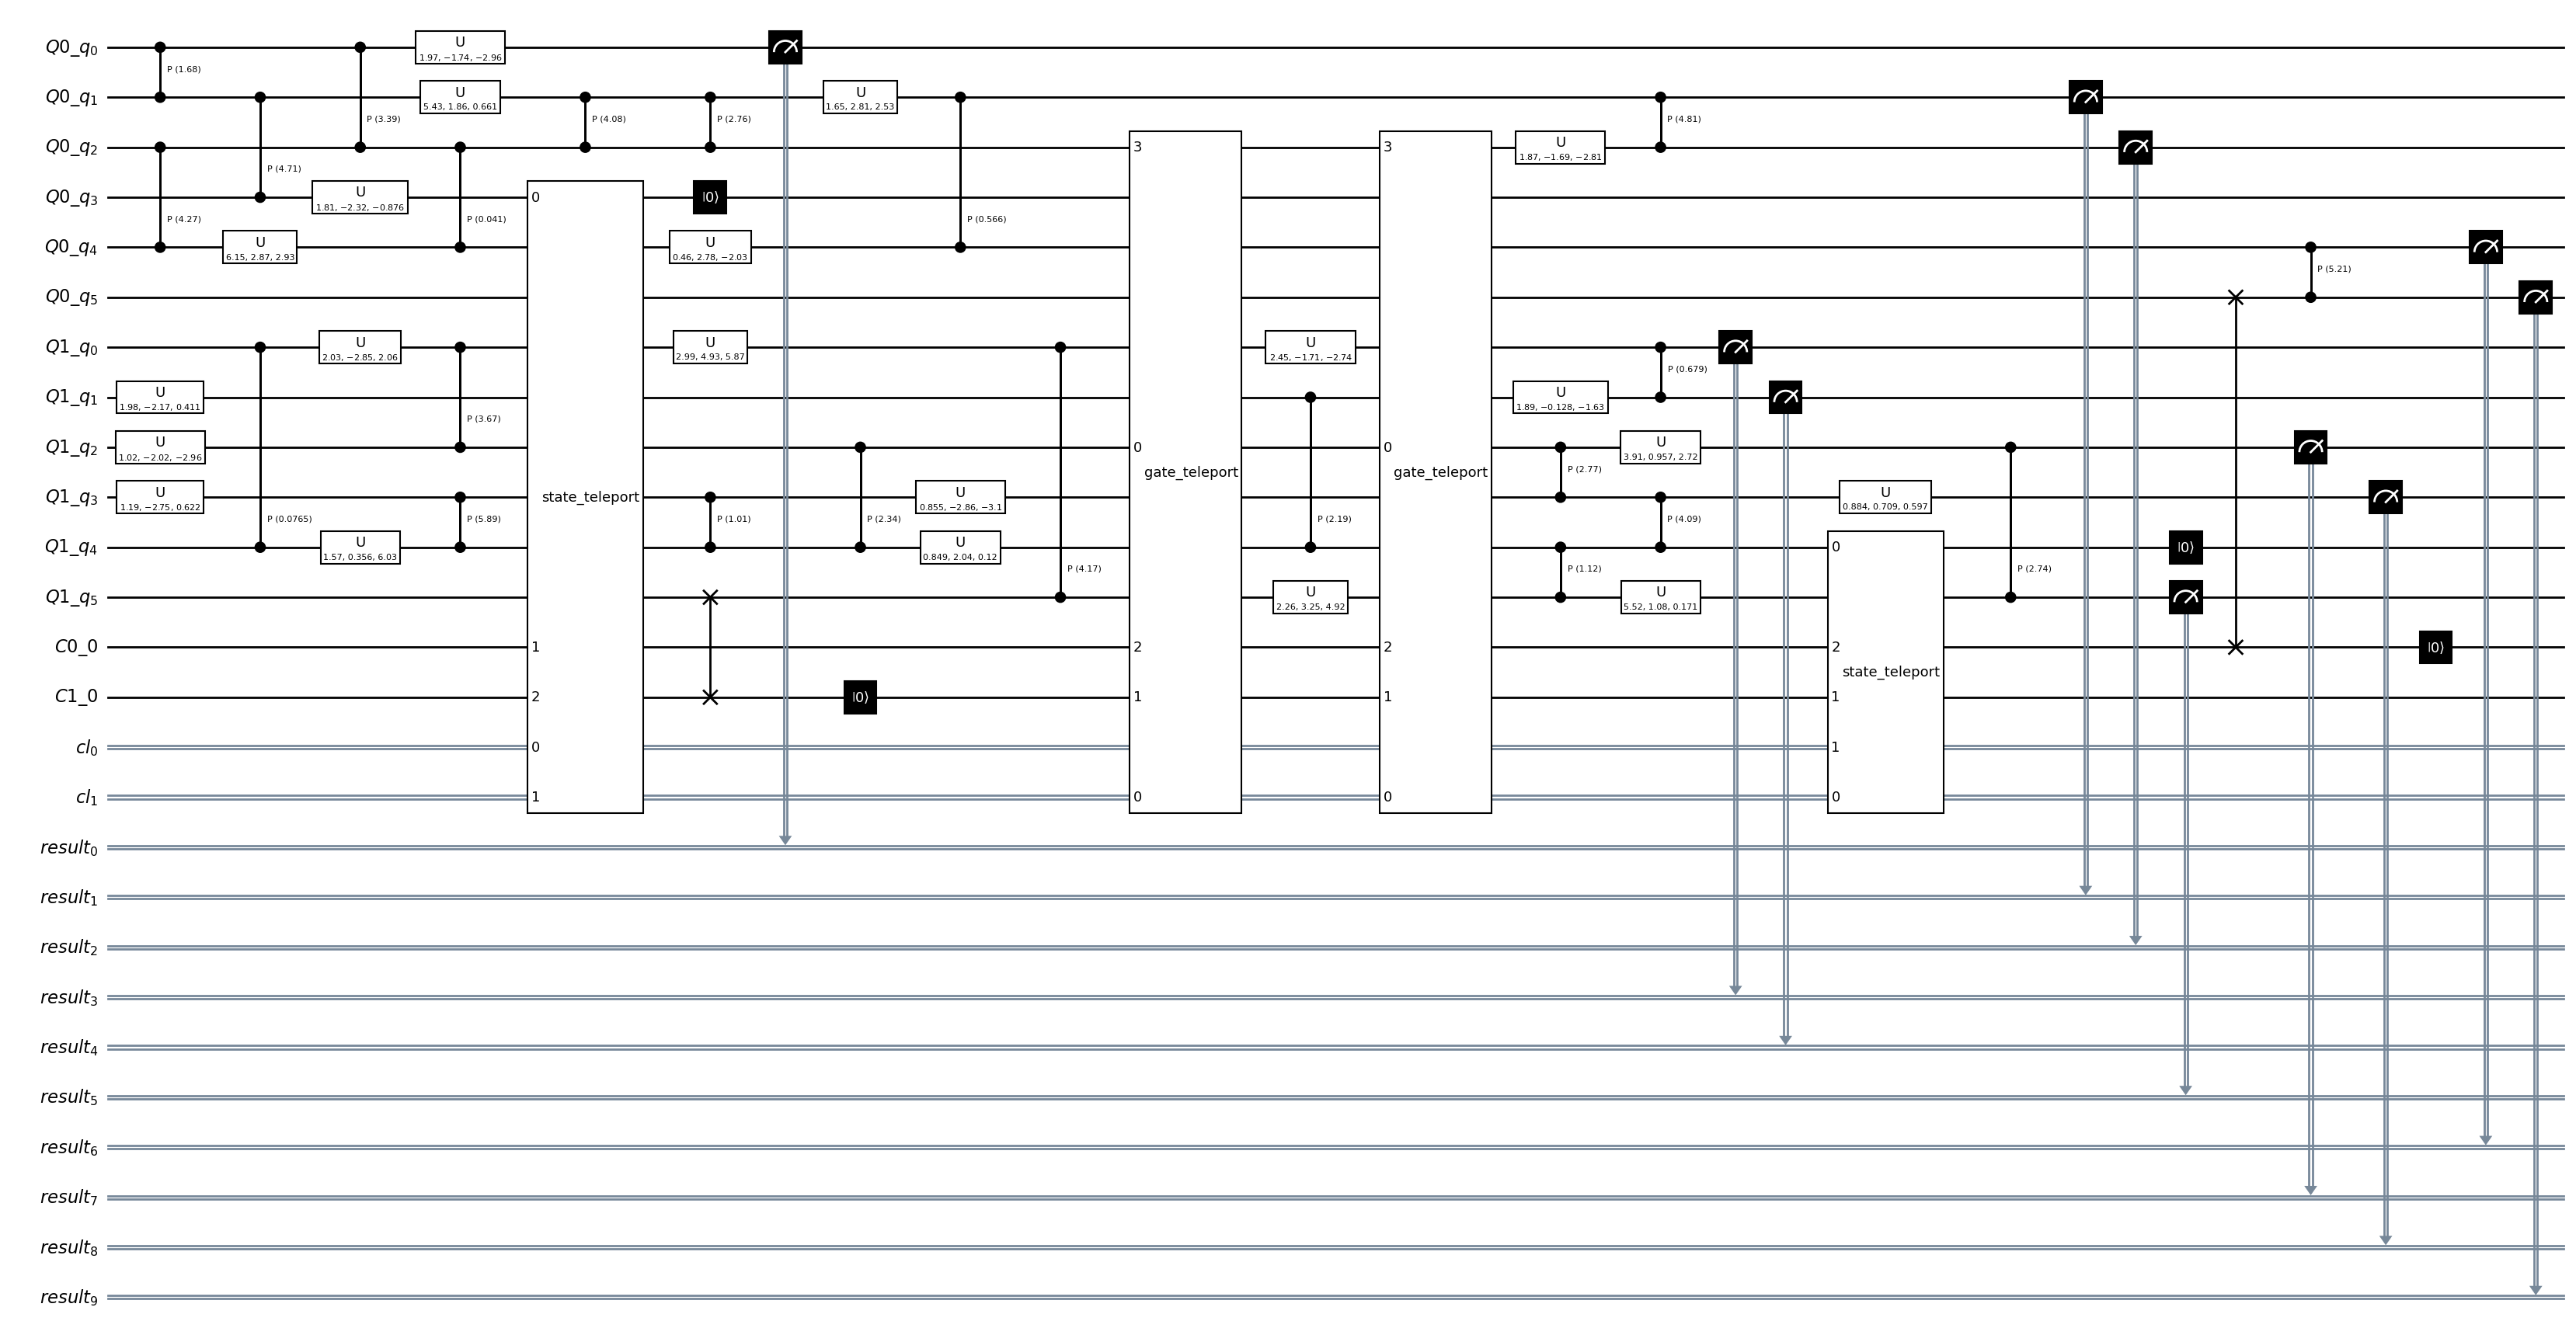

In [9]:

print(f'Decomposed circuit depth: {final_circuit.decompose().decompose().decompose().depth()}')

print(f'Number of communication qubits needed: {final_circuit.num_qubits - sum(qpu_info)}')

final_circuit.draw(output='mpl', style = 'bw', fold=100) # Draw the circuit



In [10]:

extractor_grouped = PartitionedCircuitExtractor(graph=graph_grouped, 
                                        partition_assignment=final_assignment_grouped, 
                                        qpu_info=qpu_info, 
                                        comm_info=[1]*num_partitions)

final_circuit_grouped = extractor_grouped.extract_partitioned_circuit()

Decomposed circuit depth: 69
Number of communication qubits needed: 5


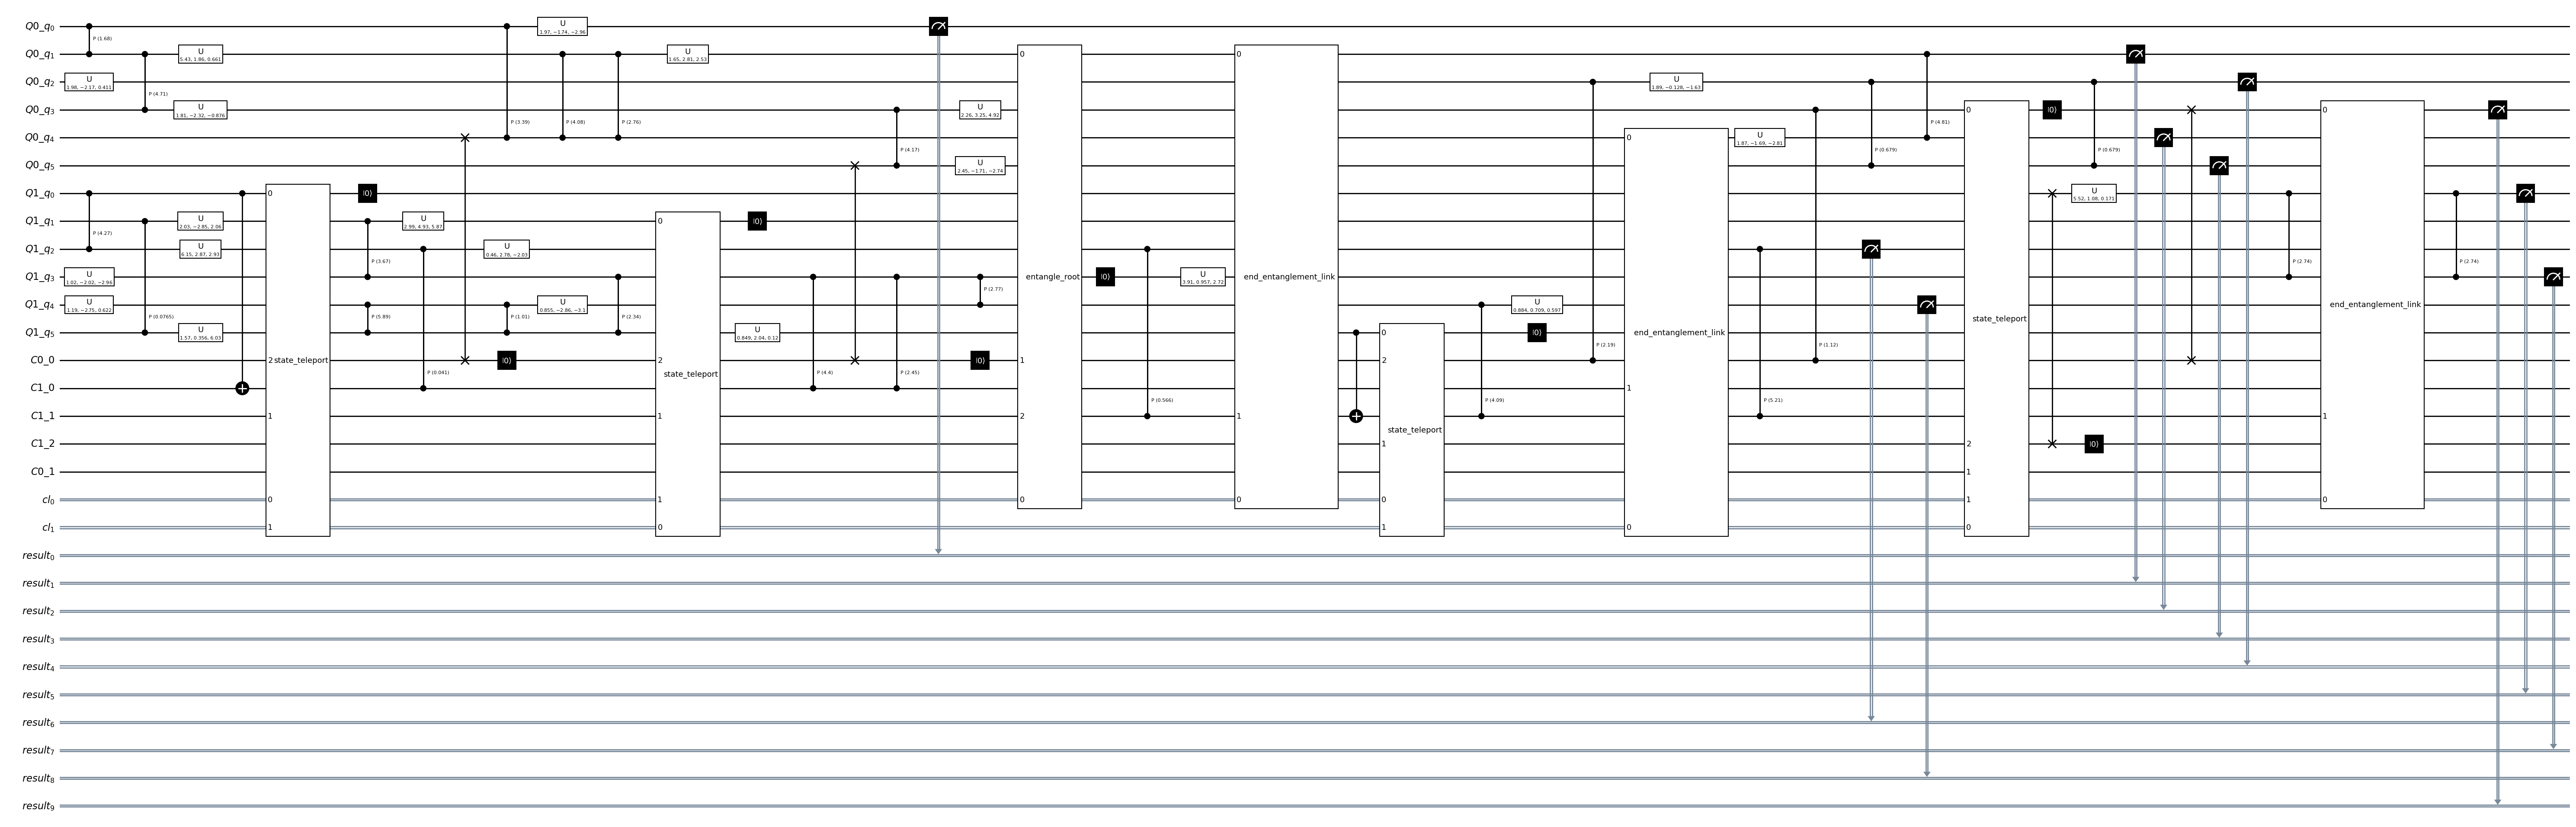

In [11]:

print(f'Decomposed circuit depth: {final_circuit_grouped.decompose().decompose().decompose().depth()}')

print(f'Number of communication qubits needed: {final_circuit_grouped.num_qubits - sum(qpu_info)}')

final_circuit_grouped.draw(output='mpl', style = 'bw', fold=100) # Draw the circuit

See circuit extraction notebook for more!

In [23]:
num_qubits_list = [16, 24, 32, 40, 48]

num_partitions = 2

depth_list = []
depth_list_grouped = []

comm_qubits_list = []
comm_qubits_list_grouped = []
iterations = 10
for num_qubits in num_qubits_list:
    qpu_info = [num_qubits // num_partitions + 1] * num_partitions # Store the number of qubits per QPU in a list
    # circuit = cp_fraction(num_qubits, num_qubits, fraction=0.3)
    circuit = QFT(num_qubits, do_swaps=False)
    circuit = transpile(circuit, basis_gates=basis_gates)

    graph = QuantumCircuitHyperGraph(circuit, group_gates=False, anti_diag=True, map_circuit=True)
    graph_grouped = QuantumCircuitHyperGraph(circuit, group_gates=True, anti_diag=True, map_circuit=True)
    depth = circuit.depth()
    node_counts = len(graph.nodes)
    move_limit = node_counts * 0.125
    assignment = set_initial_partitions(qpu_info, num_qubits, depth, num_partitions, reduced = True)
    depth_list_iteration = []
    depth_list_grouped_iteration = []
    comm_qubits_list_iteration = []
    comm_qubits_list_grouped_iteration = []
    for iteration in range(iterations):
        final_cost, final_assignment, cost_list = run_FM(graph, assignment, qpu_info, num_partitions, move_limit)
        final_cost_grouped, final_assignment_grouped, cost_list_grouped = run_FM(graph_grouped, assignment, qpu_info, num_partitions, move_limit)
        extractor = PartitionedCircuitExtractor(graph=graph,
                                                partition_assignment=final_assignment, 
                                                qpu_info=qpu_info, 
                                                comm_info=[1]*num_partitions)
        final_circuit = extractor.extract_partitioned_circuit()
        extractor_grouped = PartitionedCircuitExtractor(graph=graph_grouped, 
                                                partition_assignment=final_assignment_grouped, 
                                                qpu_info=qpu_info, 
                                                comm_info=[1]*num_partitions)
        final_circuit_grouped = extractor_grouped.extract_partitioned_circuit()
    
        circuit_EPR = transpile(final_circuit, basis_gates= basis_gates + ['EPR'])
        circuit_EPR_grouped = transpile(final_circuit_grouped, basis_gates= basis_gates + ['EPR'])

        depth_list_iteration.append(circuit_EPR.depth())
        depth_list_grouped_iteration.append(circuit_EPR_grouped.depth())
        comm_qubits_list_iteration.append(final_circuit.num_qubits - sum(qpu_info))
        comm_qubits_list_grouped_iteration.append(final_circuit_grouped.num_qubits - sum(qpu_info))

    depth_list.append(sum(depth_list_iteration) / iterations)
    depth_list_grouped.append(sum(depth_list_grouped_iteration) / iterations)
    comm_qubits_list.append(sum(comm_qubits_list_iteration) / iterations)
    comm_qubits_list_grouped.append(sum(comm_qubits_list_grouped_iteration) / iterations)

    print(f'Num qubits: {num_qubits}, depth: {circuit_EPR.depth()}, comm qubits: {final_circuit.num_qubits - sum(qpu_info)}')
    print(f'Num qubits: {num_qubits}, depth: {circuit_EPR_grouped.depth()}, comm qubits: {final_circuit_grouped.num_qubits - sum(qpu_info)}')

Num qubits: 16, depth: 255, comm qubits: 3
Num qubits: 16, depth: 66, comm qubits: 8
Num qubits: 24, depth: 396, comm qubits: 3
Num qubits: 24, depth: 127, comm qubits: 13
Num qubits: 32, depth: 533, comm qubits: 4
Num qubits: 32, depth: 203, comm qubits: 17
Num qubits: 40, depth: 761, comm qubits: 4
Num qubits: 40, depth: 227, comm qubits: 21
Num qubits: 48, depth: 972, comm qubits: 3
Num qubits: 48, depth: 290, comm qubits: 24


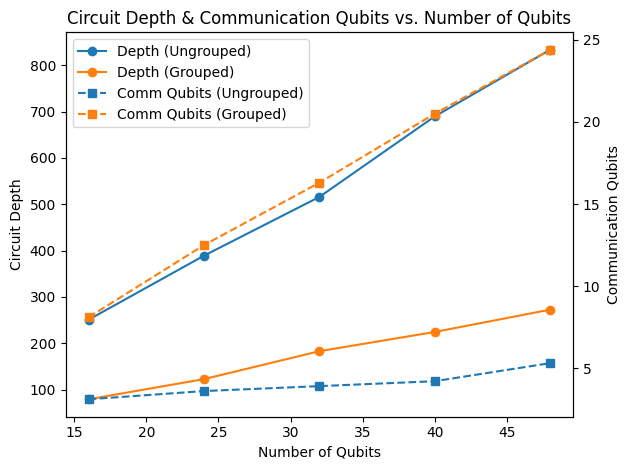

Depth list: [251.0, 389.1, 515.8, 689.5, 833.3]
Depth list grouped: [79.2, 122.7, 182.9, 224.4, 272.5]
Communication qubits list: [3.1, 3.6, 3.9, 4.2, 5.3]
Communication qubits list grouped: [8.1, 12.5, 16.3, 20.5, 24.4]


In [24]:
import matplotlib.pyplot as plt

def plot_depth_and_comm_qubits(num_qubits_list,
                               depth_list, depth_list_grouped,
                               comm_qubits_list, comm_qubits_list_grouped):
    """
    Plots circuit depth and communication-qubit requirements for normal vs.
    grouped partitions on one figure, with a shared x-axis (number of qubits)
    and dual y-axes.

    Parameters
    ----------
    num_qubits_list : list of int
        The x-axis values (list of total qubits tested).
    depth_list : list of int/float
        Circuit depth for each num_qubits for the ungrouped case.
    depth_list_grouped : list of int/float
        Circuit depth for each num_qubits for the grouped case.
    comm_qubits_list : list of int
        Communication qubits used for each num_qubits (ungrouped).
    comm_qubits_list_grouped : list of int
        Communication qubits used for each num_qubits (grouped).
    """

    fig, ax_depth = plt.subplots()
    ax_depth.set_xlabel('Number of Qubits')

    # --- Left axis: Depth ---
    ax_depth.set_ylabel('Circuit Depth')
    line_depth_ungrouped, = ax_depth.plot(num_qubits_list, depth_list, marker='o',
                                          label='Depth (Ungrouped)')
    line_depth_grouped, = ax_depth.plot(num_qubits_list, depth_list_grouped, marker='o',
                                        label='Depth (Grouped)')

    # --- Right axis: Communication qubits ---
    ax_comm = ax_depth.twinx()
    ax_comm.set_ylabel('Communication Qubits')
    line_comm_ungrouped, = ax_comm.plot(num_qubits_list, comm_qubits_list, marker='s',
                                        linestyle='--', label='Comm Qubits (Ungrouped)')
    line_comm_grouped, = ax_comm.plot(num_qubits_list, comm_qubits_list_grouped, marker='s',
                                      linestyle='--', label='Comm Qubits (Grouped)')

    # Combine all line objects for a single legend
    lines = [line_depth_ungrouped, line_depth_grouped,
             line_comm_ungrouped, line_comm_grouped]
    labels = [line.get_label() for line in lines]
    ax_depth.legend(lines, labels, loc='best')

    # Give the figure a title, tighten layout, and show
    plt.title('Circuit Depth & Communication Qubits vs. Number of Qubits')
    plt.tight_layout()
    plt.show()

plot_depth_and_comm_qubits(
    num_qubits_list,
    depth_list, depth_list_grouped,
    comm_qubits_list, comm_qubits_list_grouped
)

print(f'Depth list: {depth_list}')
print(f'Depth list grouped: {depth_list_grouped}')
print(f'Communication qubits list: {comm_qubits_list}')
print(f'Communication qubits list grouped: {comm_qubits_list_grouped}')

In [25]:
def save_data_as_dat(num_qubits_list,
                     depth_list, 
                     depth_list_grouped,
                     comm_qubits_list, 
                     comm_qubits_list_grouped,
                     filename="results.dat"):
    """
    Saves circuit depth and communication-qubit requirements data to a .dat file.

    Parameters
    ----------
    num_qubits_list : list of int
        The x-axis values (list of total qubits tested).
    depth_list : list of int/float
        Circuit depth for each num_qubits for the ungrouped case.
    depth_list_grouped : list of int/float
        Circuit depth for each num_qubits for the grouped case.
    comm_qubits_list : list of int
        Communication qubits used for each num_qubits (ungrouped).
    comm_qubits_list_grouped : list of int
        Communication qubits used for each num_qubits (grouped).
    filename : str
        Name of the output file.
    """

    # Open the file in write mode
    with open(filename, "w") as f:
        # Write a header row
        f.write("# num_qubits\tdepth_ungrouped\tdepth_grouped\tcomm_qubits_ungrouped\tcomm_qubits_grouped\n")

        # Write the data rows
        for i in range(len(num_qubits_list)):
            nq    = num_qubits_list[i]
            d_u   = depth_list[i]
            d_g   = depth_list_grouped[i]
            cq_u  = comm_qubits_list[i]
            cq_g  = comm_qubits_list_grouped[i]

            f.write(f"{nq}\t{d_u}\t{d_g}\t{cq_u}\t{cq_g}\n")

    # Print out a quick summary on-screen
    print(f"Data successfully written to {filename}")
    print(f"Depth list (ungrouped): {depth_list}")
    print(f"Depth list (grouped)  : {depth_list_grouped}")
    print(f"Comm qubits (ungrouped): {comm_qubits_list}")
    print(f"Comm qubits (grouped)   : {comm_qubits_list_grouped}")


# Example usage:
save_data_as_dat(
    num_qubits_list,
    depth_list, 
    depth_list_grouped,
    comm_qubits_list, 
    comm_qubits_list_grouped,
    filename="results.dat"
)

Data successfully written to results.dat
Depth list (ungrouped): [251.0, 389.1, 515.8, 689.5, 833.3]
Depth list (grouped)  : [79.2, 122.7, 182.9, 224.4, 272.5]
Comm qubits (ungrouped): [3.1, 3.6, 3.9, 4.2, 5.3]
Comm qubits (grouped)   : [8.1, 12.5, 16.3, 20.5, 24.4]
